[Table of Contents](./table_of_contents.ipynb)

# Адаптивная фильтрация

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

## Введение

До сих пор мы рассматривали проблему отслеживания объектов, которые хорошо ведут себя по отношению к нашей модели процесса. Например, мы можем использовать фильтр постоянной скорости для отслеживания объекта, движущегося по прямой линии. До тех пор пока объект движется по прямой с достаточно постоянной скоростью или очень медленно меняет свой путь и/или скорость, этот фильтр будет работать очень хорошо. Предположим, что мы пытаемся отследить маневрирующую цель, например автомобиль на дороге, самолет в полете и т. д. В таких ситуациях фильтры работают довольно плохо. В качестве альтернативы рассмотрим такую ситуацию, как слежение за парусником в океане. Даже если мы смоделируем управляющие воздействия, у нас не будет возможности смоделировать ветер или океанские течения. 

Подход первого порядка к этой проблеме заключается в том, чтобы сделать шум процесса $\mathbf{Q}$ больше, чтобы учесть непредсказуемость динамики системы. Хотя это может сработать в смысле обеспечения недивергентного фильтра, результат обычно далек от оптимального. Увеличение $\mathbf{Q}$ приводит к тому, что фильтр уделяет больше внимания шуму в измерениях. Пример этого мы увидим в ближайшее время.

В этой главе мы обсудим концепцию *адаптивного фильтра*. Фильтр будет *адаптироваться*, когда обнаружит динамику, которую модель процесса не может учесть. Я начну с примера проблемы, а затем обсужу и реализую различные адаптивные фильтры.

## Маневрирование цели

Нам нужна симуляция маневрирующей цели.  Я реализую простую 2D-модель с управляющими воздействиями. Вы задаете новую скорость и/или направление, и она будет изменять свое состояние в соответствии с этим.

In [3]:
from math import sin, cos, radians

def angle_between(x, y):
  return min(y-x, y-x+360, y-x-360, key=abs)

class ManeuveringTarget(object): 
    def __init__(self, x0, y0, v0, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.hdg = heading
        
        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0
    
    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx
        self.y += vy
        
        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta
        return (self.x, self.y)

    def set_commanded_heading(self, hdg_degrees, steps):
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, 
                                       self.hdg) / steps
        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0
         
    def set_commanded_speed(self, speed, steps):
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps
        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0    

Теперь давайте реализуем имитацию датчика с шумом.

In [4]:
from numpy.random import randn

class NoisySensor(object):
    def __init__(self, std_noise=1.):
        self.std = std_noise

    def sense(self, pos):
        """Pass in actual position as tuple (x, y).       
        Returns position with noise added (x,y)"""
        
        return (pos[0] + (randn() * self.std), 
                pos[1] + (randn() * self.std))

Теперь давайте сгенерируем трассу и построим ее, чтобы проверить, что все работает. Я помещу генерацию данных в функцию, чтобы мы могли создавать дорожки разной длины (почему - скоро станет ясно).

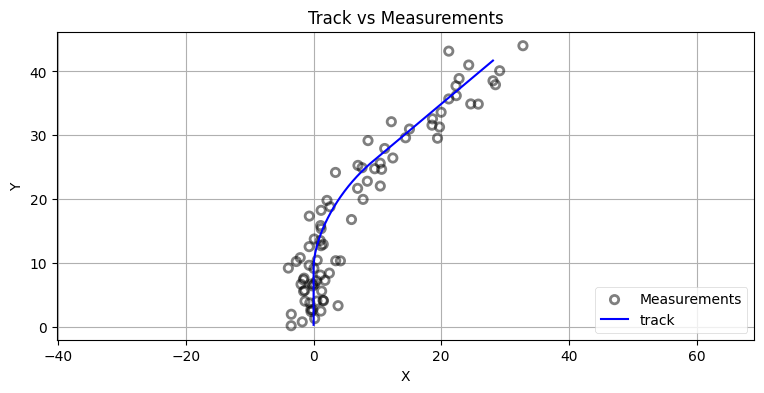

In [5]:
import kf_book.book_plots as bp
import numpy as np
import matplotlib.pyplot as plt

def generate_data(steady_count, std):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(std)
    pos = np.array(list(zip(xs, ys)))
    zs = np.array([ns.sense(p) for p in pos])
    return pos, zs

sensor_std = 2.
track, zs = generate_data(50, sensor_std)
plt.figure()
bp.plot_measurements(*zip(*zs), alpha=0.5)
plt.plot(*zip(*track), color='b', label='track')
plt.axis('equal')
plt.legend(loc=4)
bp.set_labels(title='Track vs Measurements', x='X', y='Y')

Такое большое количество шума позволяет нам легче увидеть эффект от различных вариантов дизайна.

Теперь мы можем применить фильтр Калмана для отслеживания этого объекта. Но давайте сделаем упрощение. Координаты *x* и *y* независимы, поэтому мы можем отслеживать каждую из них независимо. В оставшейся части этой главы мы будем отслеживать только координату *x*, чтобы сохранить код и матрицы как можно меньше. 

Мы начнем с фильтра постоянной скорости.

In [6]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def make_cv_filter(dt, std):
    cvfilter = KalmanFilter(dim_x = 2, dim_z=1)
    cvfilter.x = np.array([0., 0.])
    cvfilter.P *= 3
    cvfilter.R *= std**2
    cvfilter.F = np.array([[1, dt],
                           [0,  1]], dtype=float)
    cvfilter.H = np.array([[1, 0]], dtype=float)
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    return cvfilter

def initialize_filter(kf, std_R=None):
    """ helper function - we will be reinitialing the filter
    many times.
    """
    kf.x.fill(0.)
    kf.P = np.eye(kf.dim_x) * .1
    if std_R is not None:
        kf.R = np.eye(kf.dim_z) * std_R

Сейчас мы запустим это

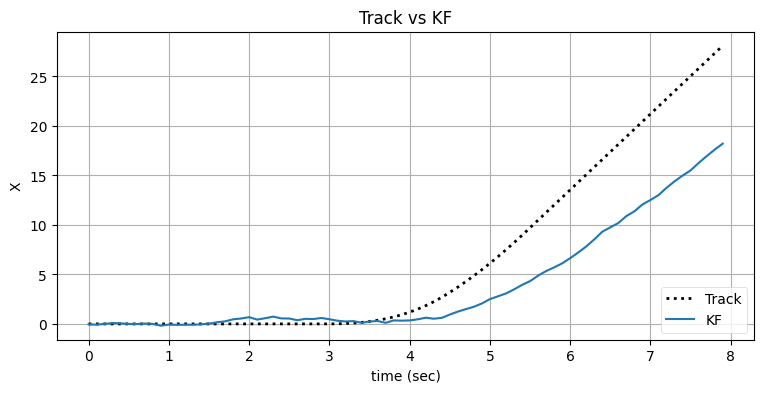

In [7]:
sensor_std = 2.
dt = 0.1

# initialize filter
cvfilter = make_cv_filter(dt, sensor_std)
initialize_filter(cvfilter)

track, zs = generate_data(50, sensor_std)

# run it
z_xs = zs[:, 0]
kxs, _, _, _ = cvfilter.batch_filter(z_xs)

# plot results
bp.plot_track(track[:, 0], dt=dt)
bp.plot_filter(kxs[:, 0], dt=dt, label='KF')
bp.set_labels(title='Track vs KF', x='time (sec)', y='X');
plt.legend(loc=4);

Из графика видно, что фильтр Калмана не смог отследить изменение курса. Вспомните из главы **g-h фильтр**, что это происходит потому, что фильтр не моделирует ускорение, поэтому он всегда будет отставать от входного сигнала. В конечном итоге фильтр догонит сигнал, если сигнал войдет в устойчивое состояние. Давайте посмотрим на это.

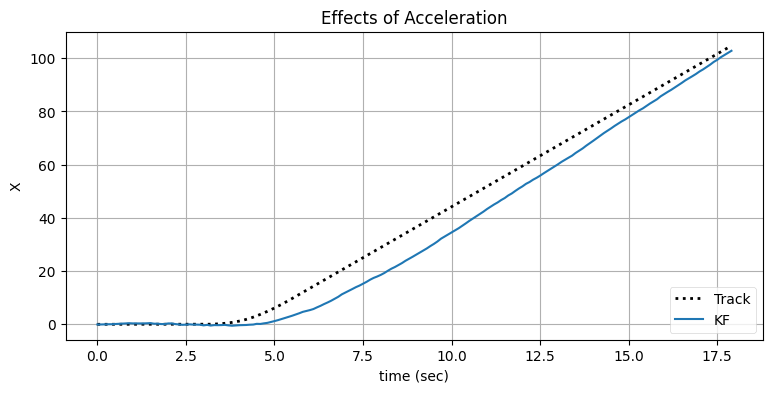

In [8]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)

track2, zs2 = generate_data(150, sensor_std)
xs2 = track2[:, 0]
z_xs2 = zs2[:, 0]

kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Effects of Acceleration', 
              x='time (sec)', y='X')

Основная проблема заключается в том, что наша модель процесса верна для участков с устойчивым состоянием, но неверна для случаев, когда объект маневрирует. Мы можем попытаться учесть это, увеличив размер Q, например, так.

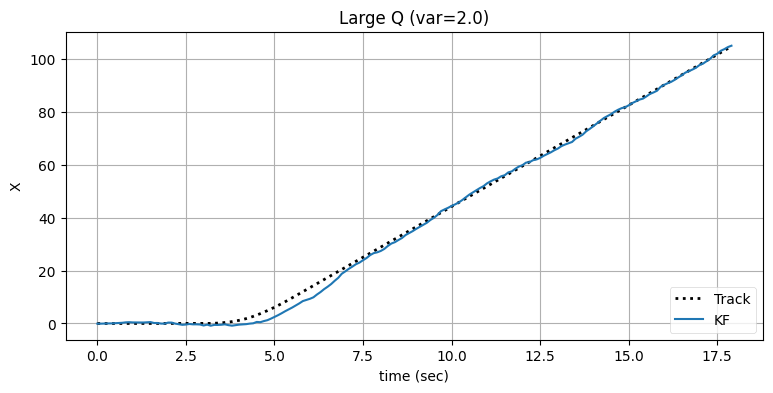

In [9]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=2.0)
track, zs = generate_data(50, sensor_std)

# recompute track
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)
bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Large Q (var=2.0)', x='time (sec)', y='X')

Мы видим, что фильтр быстрее восстанавливает трек, но ценой большого количества шума на выходе. Кроме того, во многих ситуациях отслеживания невозможно выдержать величину запаздывания, показанную между секундами 4 и 8. Мы можем уменьшить его еще больше ценой очень шумного выходного сигнала, например, так:

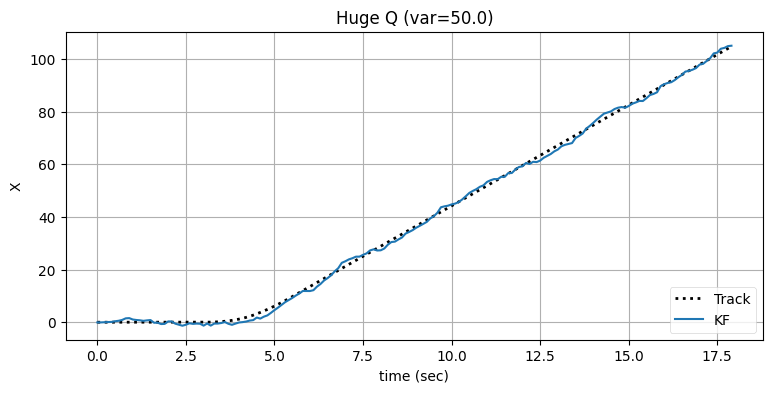

In [10]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=50.0)
track, zs = generate_data(50, sensor_std)

# recompute track
cvfilter.x.fill(0.)
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Huge Q (var=50.0)', x='time (sec)', y='X')

Маневры подразумевают ускорение, поэтому давайте применим фильтр Калмана с постоянным ускорением и посмотрим, как он справится с теми же данными.

In [11]:
def make_ca_filter(dt, std):
    cafilter = KalmanFilter(dim_x=3, dim_z=1)
    cafilter.x = np.array([0., 0., 0.])
    cafilter.P *= 3
    cafilter.R *= std
    cafilter.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
    cafilter.F = np.array([[1, dt, 0.5*dt*dt],
                           [0, 1,         dt], 
                           [0, 0,          1]])
    cafilter.H = np.array([[1., 0, 0]])
    return cafilter

def initialize_const_accel(f):
    f.x = np.array([0., 0., 0.])
    f.P = np.eye(3) * 3

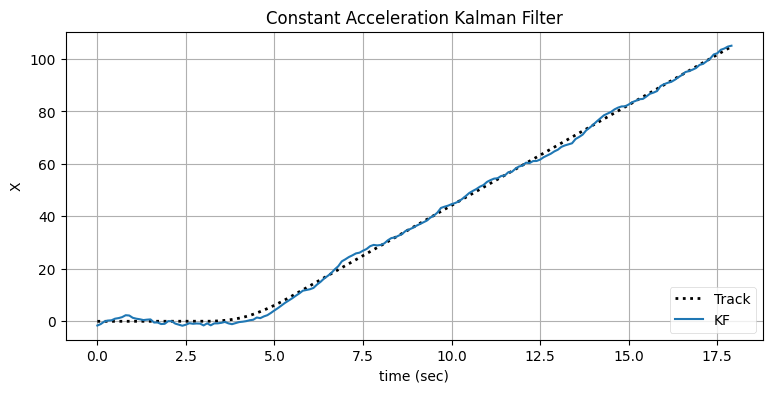

In [12]:
dt = 0.1
cafilter = make_ca_filter(dt, sensor_std)
initialize_const_accel(cafilter)

kxs2, _, _, _ = cafilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Constant Acceleration Kalman Filter',
              x='time (sec)', y='X')

Модель с постоянным ускорением способна отслеживать маневр без запаздывания, но ценой очень шумного выхода в устойчивом состоянии. Шумный выход обусловлен тем, что фильтр не может отличить начало маневра от шума в сигнале. Шум в сигнале подразумевает ускорение, и поэтому член ускорения фильтра отслеживает его. 

Кажется, мы не можем победить. Фильтр постоянной скорости не может быстро реагировать, когда цель ускоряется, а фильтр постоянного ускорения ошибочно воспринимает шум в режиме нулевого ускорения как ускорение, а не как шум.

Однако здесь есть важный момент, который приведет нас к решению. Когда цель не маневрирует (ускорение равно нулю), фильтр постоянной скорости работает оптимально. Когда цель маневрирует, фильтр постоянного ускорения работает хорошо, как и фильтр постоянной скорости с искусственно большим шумом процесса $\mathbf{Q}$. Если мы сделаем фильтр, который будет адаптироваться к поведению отслеживаемого объекта, мы сможем получить лучшее из двух вариантов.

## Детектирование маневра

Прежде чем мы обсудим, как создать адаптивный фильтр, мы должны задать вопрос: "Как мы обнаружим маневр?". Мы не можем разумно адаптировать фильтр для реагирования на маневры, если мы не знаем, когда происходит маневр.

Мы определяли *маневр* как время, когда отслеживаемый объект ускоряется, но в общем случае мы можем сказать, что объект маневрирует относительно фильтра Калмана, если его поведение отличается от модели процесса, используемой фильтром. 

Каково математическое следствие маневрирования объекта для фильтра? Объект будет вести себя не так, как предсказывает фильтр, поэтому остаток будет большим. Напомним, что остаток - это разница между текущим предсказанием фильтра и измерением. 
<img src="./figs/residual_chart.png">

Чтобы подтвердить это, давайте построим график остатка для фильтра во время маневра. Я уменьшу количество шума в данных, чтобы было легче увидеть остаток.

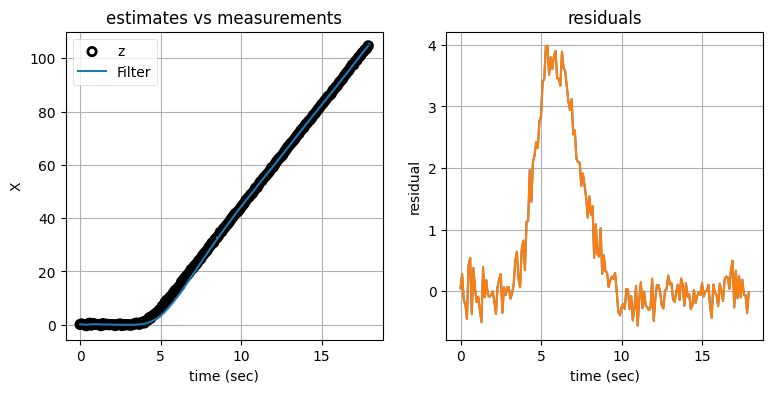

In [13]:
from kf_book.adaptive_internal import plot_track_and_residuals

def show_residual_chart():
    dt = 0.1
    sensor_std = 0.2
    
    # initialize filter
    cvfilter = make_cv_filter(dt, sensor_std)
    initialize_filter(cvfilter)
    pos2, zs2 = generate_data(150, sensor_std)
    xs2 = pos2[:, 0]
    z_xs2 = zs2[:, 0]

    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    xs, res = [], []
    for z in z_xs2:
        cvfilter.predict()
        cvfilter.update([z])
        xs.append(cvfilter.x[0])
        res.append(cvfilter.y[0])
        
    xs = np.asarray(xs)
    plot_track_and_residuals(dt, xs, z_xs2, res)

show_residual_chart();

Слева я изобразил шумные измерения на фоне выходных данных фильтра Калмана. Справа показаны невязки, вычисленные фильтром, - разница между измерениями и предсказаниями, сделанными фильтром Калмана. Позвольте мне подчеркнуть это, чтобы было понятно. График справа - это не просто разница между двумя линиями на левом графике. Левый график показывает разницу между измерениями и конечным выходом фильтра Калмана, тогда как правый график показывает разницу между измерениями и *предсказаниями модели процесса*. 

Это может показаться тонким различием, но, судя по графикам, это не так. Величина отклонения на левом графике в момент начала маневра невелика, но отклонение на правом графике говорит о другом. Если отслеживаемый объект двигался в соответствии с моделью процесса, график остаточного отклонения должен колебаться около 0,0. Это связано с тем, что измерения будут подчиняться уравнению 

$$\mathtt{measurement} = \mathtt{process\_model}(t) + \mathtt{noise}(t)$$

Как только цель начнет маневрировать, предсказания поведения цели не будут соответствовать поведению, так как уравнение будет

$$\mathtt{measurement} = \mathtt{process\_model}(t) + \mathtt{maneuver\_delta}(t) + \mathtt{noise}(t)$$

Поэтому, если остатки отклоняются от среднего значения 0,0, мы знаем, что начался маневр.

Из графика остатков видно, что нам предстоит большая работа. Мы ясно видим результат маневра на графике остатков, но количество шума в сигнале заслоняет начало маневра. Это наша старая проблема - извлечь сигнал из шума.

## Регулируем шум процесса

Первый подход, который мы рассмотрим, будет использовать модель более низкого порядка и регулировать шум процесса в зависимости от того, происходит ли маневр или нет. Когда остаток становится "большим" (для некоторого разумного определения большого), мы увеличиваем шум процесса. Это приведет к тому, что фильтр будет отдавать предпочтение измерению, а не предсказанию процесса, и фильтр будет внимательно следить за сигналом. Когда остаток станет небольшим, мы уменьшим шум процесса.

В литературе существует множество способов сделать это, я рассмотрю несколько вариантов.

### Непрерывная корректировка

Первый метод (из работы Бар-Шалома [1]) нормирует квадрат остатка с помощью следующего уравнения:

$$ \epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$$

где $\mathbf{y}$ - остаток, а $\mathbf{S}$ - неопределенность (ковариация) системы, которая имеет уравнение

$$\mathbf{S} = \mathbf{HPH^\mathsf{T}} + \mathbf{R}$$

Если линейная алгебра, используемая для его вычисления, смущает вас, вспомните, что мы можем думать об инверсиях матриц в терминах деления, поэтому $\epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$ можно представить как вычисление

$$\epsilon\approx\frac{\mathbf{y}^2}{\mathbf{S}}$$

И $\mathbf{y}$, и $\mathbf{S}$ являются атрибутами `filterpy.KalmanFilter`, так что реализация будет простой.

Давайте посмотрим на график зависимости $\epsilon$ от времени.

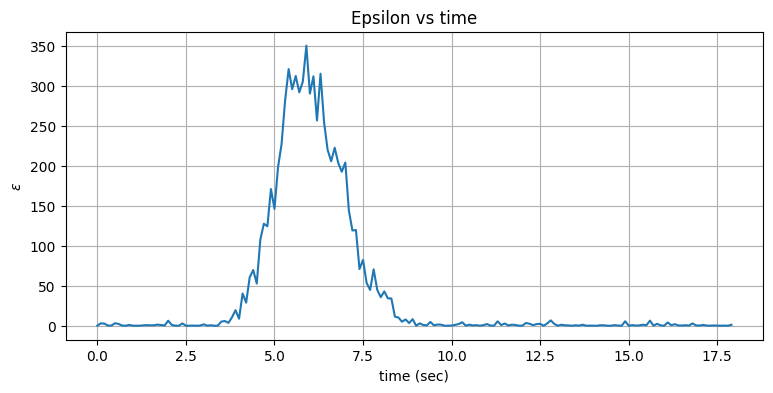

In [14]:
from numpy.linalg import inv
dt = 0.1
sensor_std = 0.2
cvfilter= make_cv_filter(dt, sensor_std)
_, zs2 = generate_data(150, sensor_std)

epss = []
for z in zs2[:, 0]:
    cvfilter.predict()
    cvfilter.update([z])
    y, S = cvfilter.y, cvfilter.S
    eps = y.T @ inv(S) @ y
    epss.append(eps)

t = np.arange(0, len(epss) * dt, dt)
plt.plot(t, epss)
bp.set_labels(title='Epsilon vs time', 
              x='time (sec)', y='$\epsilon$')

Этот график должен наглядно показать эффект нормализации остатка. Возведение остатка в квадрат гарантирует, что сигнал всегда больше нуля, а нормализация по ковариации измерений масштабирует сигнал так, что мы можем различить, когда остаток заметно изменяется по сравнению с шумом измерений. Маневр начинается в t=3 секунды, и мы видим, что $\epsilon$ начинает быстро увеличиваться вскоре после этого. 

Мы захотим начать увеличивать масштаб $\mathbf{Q}$, как только $\epsilon$ превысит некоторый предел, и уменьшать, как только он снова опустится ниже этого предела. Мы умножаем $\mathbf{Q}$ на коэффициент масштабирования. Возможно, есть литература по аналитическому выбору этого коэффициента; я вывел его экспериментально. Мы можем быть несколько более аналитичными в выборе предела для $\epsilon$ (названного $\epsilon_{max}$) - вообще говоря, если остаток превышает 3 стандартных отклонения или около того, мы можем предположить, что разница вызвана реальным изменением, а не шумом. Однако датчики редко бывают по-настоящему гауссовскими, поэтому на практике используется большее число, например 5-6 стандартных отклонений.

Я реализовал этот алгоритм, используя разумные значения для $\epsilon_{max}$ и масштабного коэффициента $\mathbf{Q}$. Чтобы упростить проверку результатов, я ограничил график первыми 10 секундами симуляции.

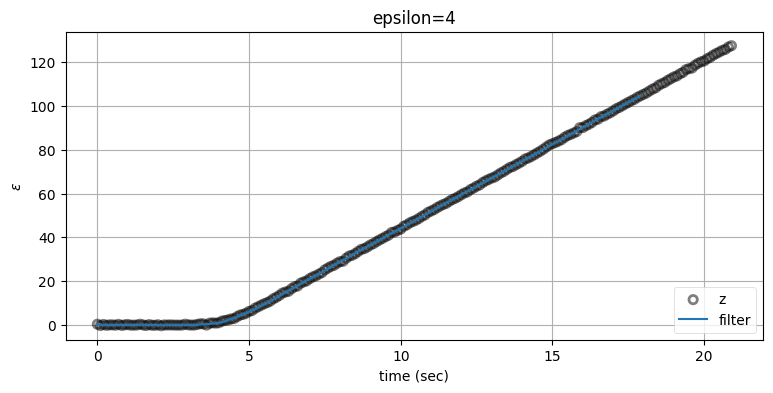

In [15]:
# reinitialize filter
dt = 0.1
sensor_std = 0.2
cvfilter = make_cv_filter(dt, sensor_std)
_, zs2 = generate_data(180, sensor_std)

Q_scale_factor = 1000.
eps_max = 4.

xs, epss = [], []

count = 0
for i, z in zip(t, zs2[:, 0]):
    cvfilter.predict()
    cvfilter.update([z])
    y, S = cvfilter.y, cvfilter.S
    eps = y.T @ inv(S) @ y
    epss.append(eps)
    xs.append(cvfilter.x[0])

    if eps > eps_max:
        cvfilter.Q *= Q_scale_factor
        count += 1
    elif count > 0:
        cvfilter.Q /= Q_scale_factor
        count -= 1

bp.plot_measurements(zs2[:,0], dt=dt, label='z', alpha=0.5)
bp.plot_filter(t, xs, label='filter')
plt.legend(loc=4)
bp.set_labels(title='epsilon=4', x='time (sec)', y='$\epsilon$')

Производительность этого фильтра заметно выше, чем у фильтра постоянной скорости. Фильтру постоянной скорости потребовалось около 10 секунд, чтобы восстановить сигнал после начала маневра. Адаптивному фильтру для этого требуется менее секунды.

### Непрерывная корректировка - версия стандартного отклонения

Другой, очень похожий метод Зарчана [2] устанавливает предел на основе стандартного отклонения ковариации ошибки измерения. Здесь уравнения имеют вид:

$$ \begin{aligned}
std &= \sqrt{\mathbf{HPH}^\mathsf{T} + \mathbf{R}} \\
&= \sqrt{\mathbf{S}}
\end{aligned}
$$

Если абсолютное значение остатка больше некоторого кратного стандартного отклонения, вычисленного выше, мы увеличиваем шум процесса на фиксированную величину, пересчитываем Q и продолжаем.

/var/folders/9r/x5ypg1z565b7mkpx1jq005980000gn/T/ipykernel_55506/1359931609.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std = sqrt(S)


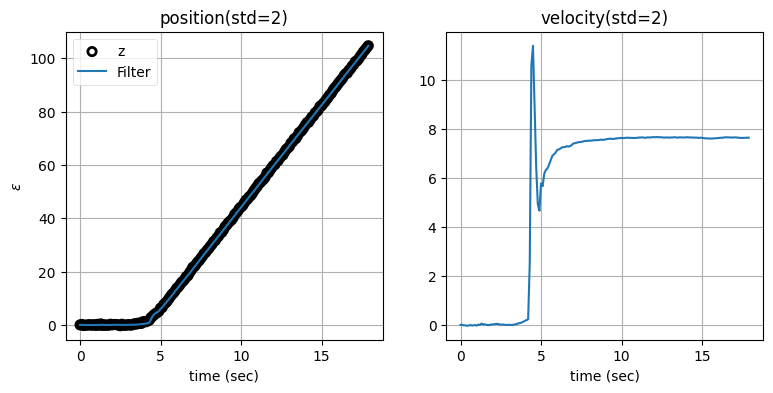

In [16]:
from math import sqrt

def zarchan_adaptive_filter(Q_scale_factor, std_scale, 
                            std_title=False,
                            Q_title=False):
    cvfilter = make_cv_filter(dt, std=0.2)
    pos2, zs2 = generate_data(180-30, std=0.2)
    xs2 = pos2[:,0]
    z_xs2 = zs2[:,0]

    # reinitialize filter
    initialize_filter(cvfilter)
    cvfilter.R = np.eye(1)*0.2

    phi = 0.02
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=phi)
    xs, ys = [], []
    count = 0
    for z in z_xs2:
        cvfilter.predict()
        cvfilter.update([z])
        y = cvfilter.y
        S = cvfilter.S
        std = sqrt(S)

        xs.append(cvfilter.x)
        ys.append(y)

        if abs(y[0]) > std_scale*std:
            phi += Q_scale_factor
            cvfilter.Q = Q_discrete_white_noise(2, dt, phi)
            count += 1
        elif count > 0:
            phi -= Q_scale_factor
            cvfilter.Q = Q_discrete_white_noise(2, dt, phi)
            count -= 1

    xs = np.asarray(xs)
    plt.subplot(121)
    bp.plot_measurements(z_xs2, dt=dt, label='z')
    bp.plot_filter(xs[:, 0], dt=dt, lw=1.5)
    bp.set_labels(x='time (sec)', y='$\epsilon$')
    plt.legend(loc=2)
    if std_title:
        plt.title(f'position(std={std_scale})')
    elif Q_title:
        plt.title(f'position(Q scale={Q_scale_factor})')
    else:
        plt.title('position')
        
    plt.subplot(122)
    plt.plot(np.arange(0, len(xs)*dt, dt), xs[:, 1], lw=1.5)
    plt.xlabel('time (sec)')
    if std_title:
        plt.title(f'velocity(std={std_scale})')
    elif Q_title:
        plt.title(f'velocity(Q scale={Q_scale_factor})')
    else:
        plt.title('velocity')        
    plt.show()
 
zarchan_adaptive_filter(1000, 2, std_title=True)

Поэтому я решил использовать 1000 в качестве масштабного коэффициента для шума и 2 в качестве предела стандартного отклонения. Почему именно эти цифры? Во-первых, давайте посмотрим на разницу между 2 и 3 стандартными отклонениями.

**Два стандартных отклонения**

/var/folders/9r/x5ypg1z565b7mkpx1jq005980000gn/T/ipykernel_55506/1359931609.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std = sqrt(S)


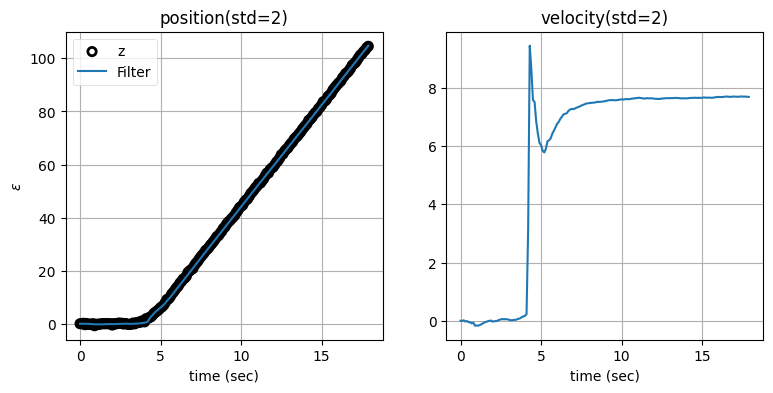

In [17]:
zarchan_adaptive_filter(1000, 2, std_title=True)

**Три стандартных отклонения**

/var/folders/9r/x5ypg1z565b7mkpx1jq005980000gn/T/ipykernel_55506/1359931609.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std = sqrt(S)


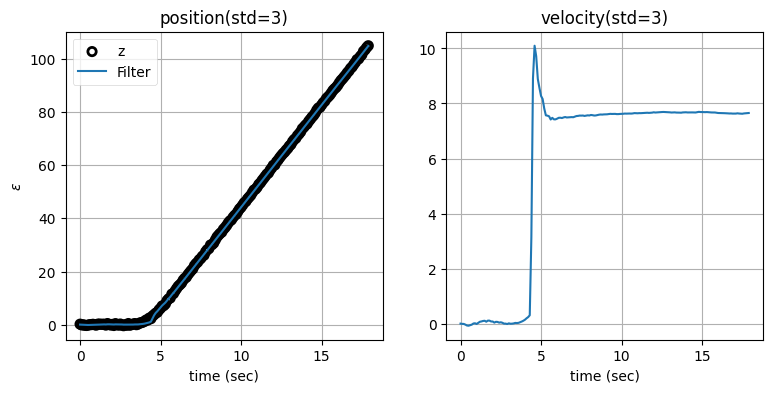

In [18]:
zarchan_adaptive_filter(1000, 3, std_title=True)

Из графиков видно, что выход фильтра для положения очень похож, независимо от того, используем мы 2 стандартных отклонения или 3. А вот вычисление скорости - совсем другое дело. Давайте исследуем это дальше. Во-первых, сделаем стандартное отклонение очень маленьким.

/var/folders/9r/x5ypg1z565b7mkpx1jq005980000gn/T/ipykernel_55506/1359931609.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std = sqrt(S)


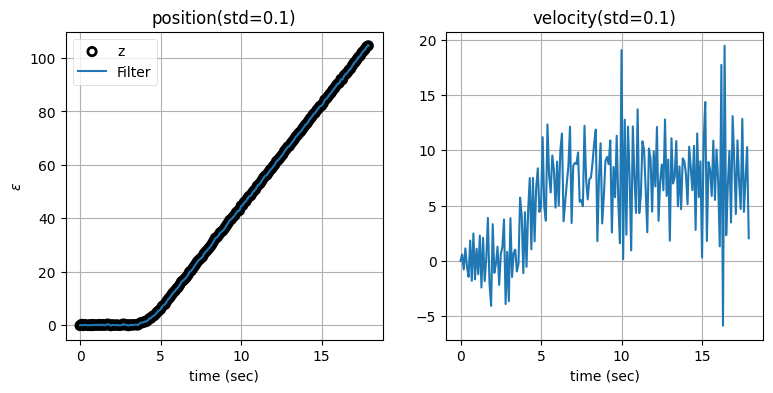

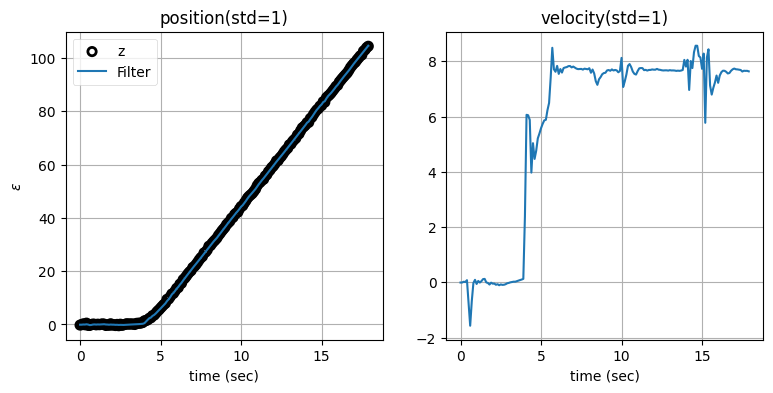

In [19]:
zarchan_adaptive_filter(1000, .1, std_title=True)
zarchan_adaptive_filter(1000, 1, std_title=True)

По мере уменьшения предела стандартного отклонения вычисление скорости становится все хуже. Подумайте, почему это так. Если мы начнем изменять фильтр так, чтобы он отдавал предпочтение измерению, а не предсказанию, как только остаток хоть немного отклонится от предсказания, мы очень быстро отдадим почти весь вес измерению. При отсутствии веса для предсказания у нас нет информации, на основе которой можно было бы создать скрытые переменные. Таким образом, когда предел составляет 0,1 std, вы можете видеть, что скорость подавляется шумом в измерении. С другой стороны, поскольку мы так благосклонно относимся к измерениям, положение следует за маневром почти идеально.

Теперь давайте посмотрим на влияние различных приращений шума процесса. Здесь я ограничил стандартное отклонение до 2 std и варьировал инкремент от 1 до 10 000.

/var/folders/9r/x5ypg1z565b7mkpx1jq005980000gn/T/ipykernel_55506/1359931609.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std = sqrt(S)


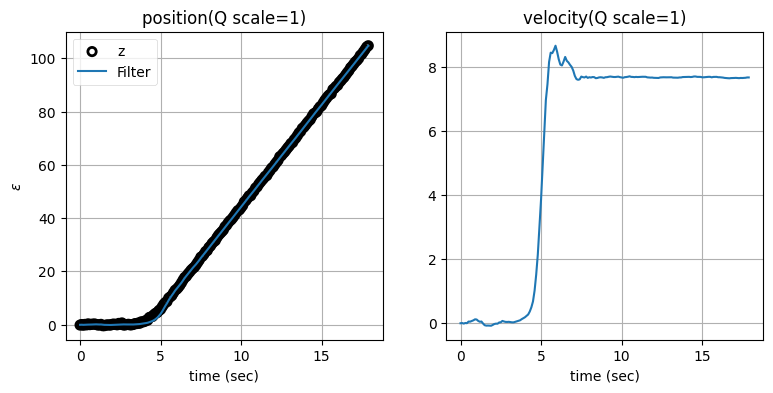

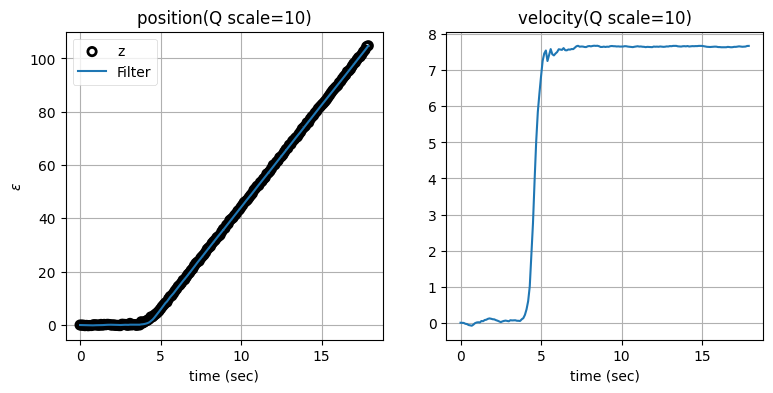

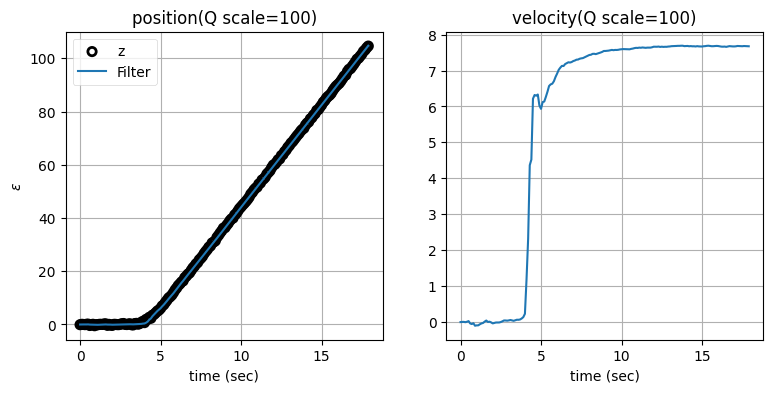

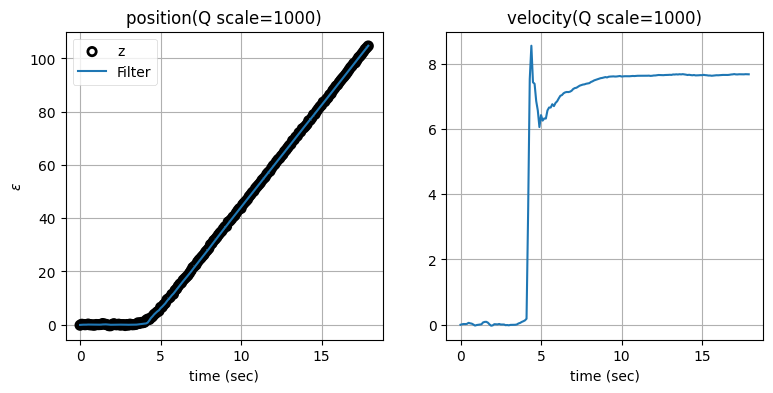

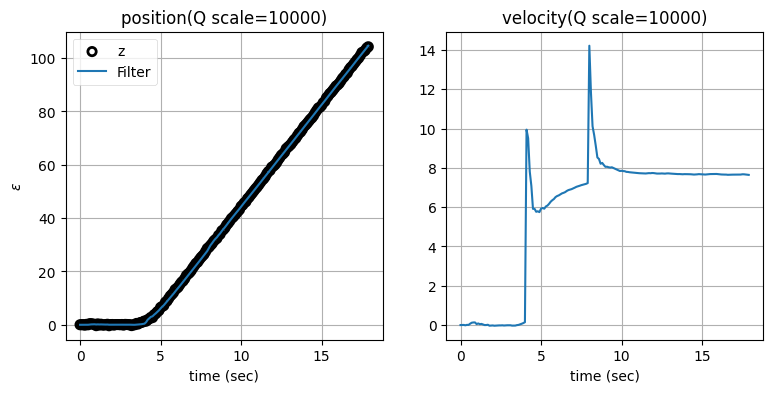

In [20]:
zarchan_adaptive_filter(1, 2, Q_title=True)
zarchan_adaptive_filter(10, 2, Q_title=True)
zarchan_adaptive_filter(100, 2, Q_title=True)
zarchan_adaptive_filter(1000, 2, Q_title=True)
zarchan_adaptive_filter(10000, 2, Q_title=True)

Здесь мы видим, что оценка положения становится немного лучше при увеличении коэффициента приращения, но оценка скорости начинает создавать большой перебор. 

Я не могу сказать вам, какой из этих вариантов "правильный". Вам нужно будет проверить работу фильтра на реальных и смоделированных данных и выбрать конструкцию, которая наилучшим образом соответствует необходимым характеристикам для каждой из переменных состояния.

## Фильтр угасающей памяти

Фильтры с затухающей памятью обычно не классифицируются как адаптивные фильтры, поскольку они не адаптируются к входным данным, но они обеспечивают хорошую производительность при работе с маневрирующими целями. Их преимущество также в том, что они имеют очень простую вычислительную форму для кинематических фильтров первого, второго и третьего порядка (например, фильтров, которые мы используем в этой главе). Эта простая форма не требует уравнений Рикатти для вычисления коэффициента усиления фильтра Калмана, что значительно сокращает объем вычислений. Однако существует также форма, которая работает со стандартным фильтром Калмана. В этой главе я сосредоточусь на последней форме, поскольку наше внимание больше сосредоточено на адаптивных фильтрах. Обе формы фильтра с затухающей памятью реализованы в `FilterPy`.

Фильтр Калмана является рекурсивным, но он включает все предыдущие измерения в текущий расчет коэффициента усиления фильтра. Если поведение цели согласуется с моделью процесса, это позволяет фильтру Калмана находить оптимальную оценку для каждого измерения. Рассмотрим летящий мяч - мы можем оценить положение мяча в момент времени t лучше, если учтем все предыдущие измерения. Если бы мы использовали только некоторые из измерений, мы были бы менее уверены в текущем положении и, следовательно, больше подвержены влиянию шума в измерениях. Если это все еще не ясно, рассмотрим наихудший случай. Предположим, мы забудем все измерения и оценки, кроме последних. Тогда у нас не будет никакой уверенности в положении и траектории мяча, и у нас не будет другого выбора, кроме как сильно взвесить текущее измерение. Если измерение зашумлено, то и оценка будет зашумленной. Мы наблюдаем этот эффект каждый раз, когда инициализируется фильтр Калмана. Первые оценки зашумлены, но затем они успокаиваются по мере получения большего количества измерений.

Однако если цель маневрирует, она не всегда ведет себя так, как предсказывает модель процесса. В этом случае запоминание всех прошлых измерений и оценок становится помехой. Мы видим это на всех приведенных выше графиках. Цель начинает поворот, а фильтр Калмана продолжает прогнозировать движение по прямой. Это происходит потому, что фильтр построил историю движения цели и ошибочно "чувствует" уверенность в том, что цель движется по прямой линии с заданным курсом и скоростью. 

Фильтр с угасающей памятью решает эту проблему, придавая меньший вес старым измерениям и больший вес более свежим.

Существует множество формулировок для затухающего фильтра памяти; я использую формулировку, предложенную Дэном Саймоном в *Optimal State Estimation* [3]. Я не буду рассматривать его вывод, а лишь приведу результаты.

Уравнение фильтра Калмана для ковариаций ошибки оценивания имеет вид

$$ \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q $$

Мы можем заставить фильтр забыть о прошлых измерениях, умножив член $\alpha$

$$ \tilde{\mathbf P} = \alpha^2\mathbf{FPF}^\mathsf T + \mathbf Q$$

где $\alpha > 1.0$. Если $\alpha == 1$, то мы получаем обычную работу фильтра Калмана. $\alpha$ - это атрибут класса `KalmanFilter`; его значение по умолчанию равно 1, поэтому фильтр работает как фильтр Калмана, если $\alpha$ не присвоено значение, отличное от 1. Нет жесткого и быстрого правила для выбора $\alpha$, но обычно оно очень близко к 1, например, 1.01. Вам нужно будет провести много прогонов с симулированными или реальными данными, чтобы определить значение, которое реагирует на маневры, не приводя к тому, что оценка становится слишком шумной из-за чрезмерного взвешивания шумных измерений.

Почему это работает? Если мы увеличиваем ковариацию ошибки оценки, фильтр становится более неуверенным в своей оценке, поэтому он придает больший вес измерению.

Одно предостережение - если мы используем $\alpha$, то мы вычисляем $\tilde{\mathbf P}$, а не $\bar{\mathbf P}$. Другими словами, `KalmanFilter.P` *не* равно ковариации предшественника, поэтому не стоит относиться к нему так, как будто это так.

Давайте отфильтруем наши данные с помощью фильтра затухающей памяти и посмотрим на результат. Я введу в систему большое количество ошибок, чтобы мы могли сравнить различные подходы.

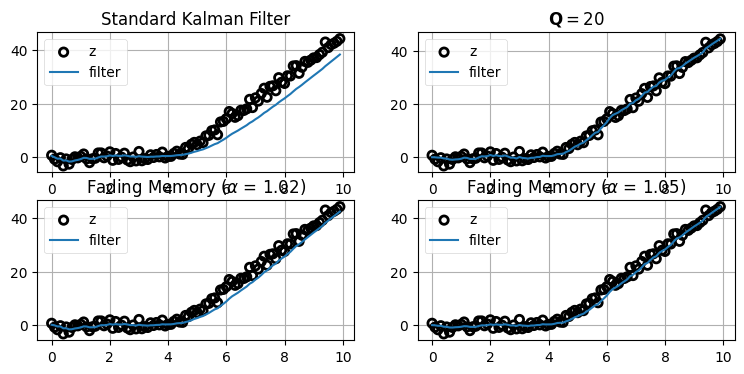

In [21]:
pos2, zs2 = generate_data(70, std=1.2)
xs2 = pos2[:, 0]
z_xs2 = zs2[:, 0]

cvfilter = make_cv_filter(dt, std=1.2)
cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.00

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(221)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Standard Kalman Filter')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=20.)
cvfilter.alpha = 1.00

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
    
xs = np.asarray(xs)

plt.subplot(222)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('$\mathbf{Q}=20$')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.02

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(223)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Fading Memory ($\\alpha$ = 1.02)')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.05

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(224)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Fading Memory ($\\alpha$ = 1.05)');

На первом графике показана работа фильтра Калмана. Фильтр расходится с началом маневра и восстанавливает сигнал только через 10 секунд. Затем я заставил фильтр отслеживать маневр очень быстро, сделав шум процесса большим, но это привело к тому, что оценка фильтра стала очень шумной из-за чрезмерного взвешивания шумных измерений. Затем я применил фильтр с затухающей памятью с $\alpha=1.02$. Отфильтрованная оценка получается очень гладкой, но ей требуется несколько секунд для сходимости, когда цель возвращается к устойчивому состоянию. Однако время сходимости значительно меньше, чем у фильтра Калмана, и величина отставания гораздо меньше - оценка для затухающей памяти гораздо ближе к реальному треку, чем трек фильтра Калмана. Наконец, я увеличил $\alpha$ до 1,05. Здесь мы видим, что фильтр почти мгновенно реагирует на маневр, но оценка не такая прямая во время установившегося режима работы, потому что фильтр забывает прошлые измерения. 

Это довольно хорошая производительность для такого небольшого изменения в коде! Обратите внимание, что здесь нет "правильного" выбора. Вы должны разработать свой фильтр, основываясь на своих потребностях и характеристиках шума измерений, шума процесса и поведения цели при маневрировании.

## Оценка по нескольким моделям 

В примере, который я использую в этой главе, цель движется в устойчивом состоянии, совершает маневр, а затем возвращается в устойчивое состояние. Мы рассматривали это как две модели - модель постоянной скорости и модель постоянного ускорения. Всякий раз, когда вы можете описать систему как подчиняющуюся одной из конечного набора моделей, вы можете использовать *Многомодельное (ММ) оценивание*. Мы используем банк из нескольких фильтров, каждый из которых использует свой процесс для описания системы, и либо переключаемся между ними, либо смешиваем их в зависимости от динамики отслеживаемого объекта. 

Как вы понимаете, это обширная тема, и существует множество способов разработки и реализации ММ-оценщиков. Но рассмотрим простой подход для цели, которую мы отслеживали в этой главе. Одна из идей заключается в том, чтобы одновременно запустить фильтр постоянной скорости и фильтр постоянного ускорения и переключаться между их выходами, когда мы обнаруживаем маневр, проверяя остатки. Даже такой выбор дает нам множество вариантов. Рассмотрим динамику поворота объекта. Например, автомобиль поворачивает на колесной базе - передние колеса поворачиваются, и машина поворачивается вокруг задних колес. Это нелинейный процесс, поэтому для достижения наилучших результатов мы бы хотели использовать какой-либо тип нелинейного фильтра (EKF, UKF и т. д.) для моделирования поворотов. С другой стороны, линейный фильтр постоянной скорости будет отлично работать для устойчивых участков движения. Таким образом, наш банк фильтров может состоять из линейного KF и EKF для поворотов. Однако ни один из них не подходит для моделирования поведения, например, ускорения и торможения. Таким образом, высокоэффективный оценщик ММ может содержать банк из множества фильтров, каждый из которых предназначен для лучшей работы в определенном диапазоне характеристик отслеживаемого объекта.

Конечно, не обязательно основывать свои фильтры на порядке модели. Вы можете использовать разные модели шума, разные адаптеры в каждой из них. Например, в разделе выше я показал множество графиков, изображающих влияние изменения параметров на оценку скорости и положения. Возможно, одна настройка лучше работает для положения, а другая - для скорости. Поместите оба параметра в банк фильтров. Затем вы можете взять лучшие оценки для положения из одного фильтра и лучшие оценки для скорости из другого фильтра.

### Адаптивный фильтр с двумя фильтрами

Идея переключения между фильтрами для достижения наилучшей производительности ясна, но какие математические основы мы должны использовать для ее реализации? Проблема, с которой мы сталкиваемся, заключается в попытке обнаружить по зашумленным измерениям, когда изменение режима должно привести к изменению модели. Какой аспект фильтра Калмана измеряет, насколько сильно измерение отклоняется от предсказания? Да, *резидуальный*.

Допустим, у нас есть фильтр Калмана первого порядка (с постоянной скоростью). До тех пор, пока цель не маневрирует, фильтр будет точно отслеживать ее поведение, и примерно 68% измерений должны попадать в пределы 1$\sigma$. Кроме того, остаток должен колебаться около 0, поскольку, если датчик гауссовский, равное количество измерений должно иметь положительную ошибку, равно как и отрицательную. Если остаток растет и остается за пределами предсказанных границ, значит, цель работает не так, как предсказывает модель состояния. Мы видели это ранее на этом графике, где остаток переключился с прыжков вокруг 0 на внезапный скачок и пребывание выше нуля, как только отслеживаемый объект начал маневрировать.

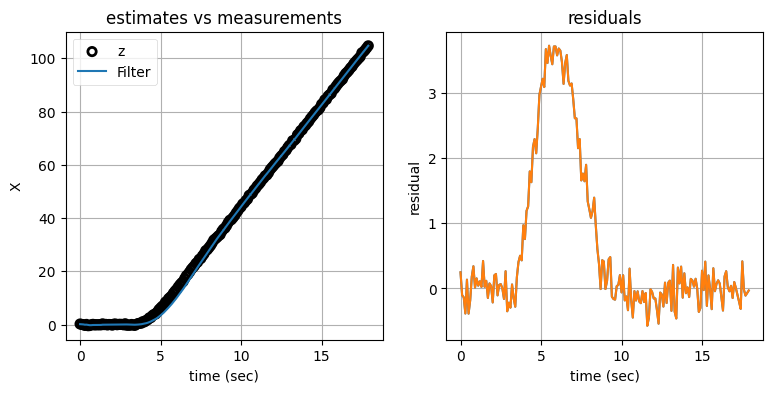

In [22]:
show_residual_chart()

Для этой задачи мы увидели, что фильтр постоянной скорости работает лучше фильтра постоянного ускорения, пока объект находится в устойчивом состоянии, и наоборот, когда объект маневрирует. На графике выше этот переход происходит на 4 секунде. 

Итак, алгоритм прост. Инициализируйте фильтр постоянной скорости и фильтр постоянного ускорения и запустите их вместе в цикле предсказания/обновления. После каждого обновления проверяйте остаток фильтра постоянной скорости. Если он попадает в теоретические рамки, используйте оценку фильтра постоянной скорости в качестве оценки, в противном случае используйте оценку фильтра постоянного ускорения.

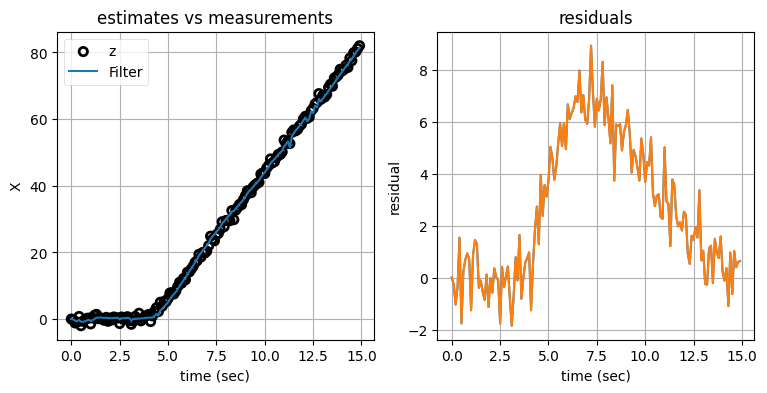

In [23]:
def run_filter_bank(threshold, show_zs=True):
    dt = 0.1
    cvfilter= make_cv_filter(dt, std=0.8)
    cafilter = make_ca_filter(dt, std=0.8)
    pos, zs = generate_data(120, std=0.8)
    z_xs = zs[:, 0]
    xs, res = [], []

    for z in z_xs:
        cvfilter.predict()
        cafilter.predict()
        cvfilter.update([z])
        cafilter.update([z])
        
        std = np.sqrt(cvfilter.R[0,0])
        if abs(cvfilter.y[0]) < 2 * std:
            xs.append(cvfilter.x[0])
        else:
            xs.append(cafilter.x[0])
        res.append(cvfilter.y[0])
    xs = np.asarray(xs)
    if show_zs:
        plot_track_and_residuals(dt, xs, z_xs, res)
    else:
        plot_track_and_residuals(dt, xs, None, res)

run_filter_bank(threshold=1.4)

Здесь фильтр точно отслеживает маневр. Пока цель не маневрирует, наша оценка практически свободна от шума, а как только она начинает маневрировать, мы быстро обнаруживаем это и переключаемся на фильтр постоянного ускорения. Однако он не идеален. Здесь показан выход фильтра в одиночку:

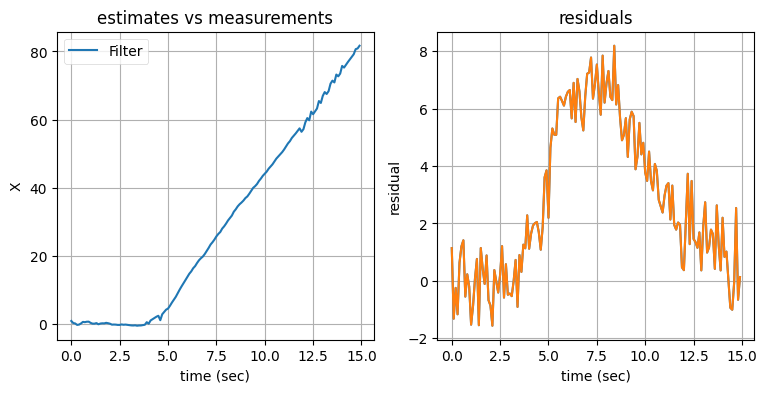

In [24]:
run_filter_bank(threshold=1.4, show_zs=False)

Видно, что оценка скачет, когда банк фильтров переключается с одного фильтра на другой. Я бы не стал использовать этот алгоритм в производственной системе. В следующем разделе приводится современная реализация банка фильтров, которая устраняет эту проблему.

## MMAE

Основная идея использования нескольких фильтров для обнаружения маневра здравая, но оценка получается неровной, когда мы резко переходим от одного фильтра к другому. Выбор одного фильтра вместо другого идет вразрез со всей этой книгой, в которой вероятность используется для определения *вероятности* измерений и моделей. Мы не выбираем *какое-то* измерение или предсказание в зависимости от того, какое из них более вероятно, мы выбираем *смесь* из двух в пропорции к их вероятности. То же самое мы должны делать и здесь. Этот подход называется *Адаптивный оценщик множественных моделей*, или MMAE.

В главе **Разработка фильтров Калмана** мы изучили *функцию правдоподобия*.

$$\mathcal{L} = \frac{1}{\sqrt{2\pi S}}\exp [-\frac{1}{2}\mathbf{y}^\mathsf{T}\mathbf{S}^{-1}\mathbf{y}]$$

который говорит нам о том, насколько вероятно, что фильтр работает оптимально, учитывая входные данные. $\mathbf y$ - это остаток, а $\mathbf S$ - неопределенность системы (ковариация в пространстве измерений). Это просто гаусс от остатка и неопределенности системы. Большой остаток дает большую неопределенность и, следовательно, низкую вероятность того, что измерение соответствует текущему состоянию фильтра. Мы можем использовать это для вычисления вероятности того, что каждый фильтр наилучшим образом соответствует данным. Если у нас есть N фильтров, мы можем вычислить вероятность того, что фильтр i является правильным по отношению к остальным фильтрам, используя

$$p_k^i = \frac{\mathcal{L}_k^ip_{k-1}^i}{\sum\limits_{j=1}^N \mathcal{L}_k^jp_{k-1}^j}$$

Это выглядит запутанно, но на самом деле все просто. Числитель - это просто вероятность на данном временном шаге, умноженная на вероятность того, что данный фильтр был правильным на последнем временном интервале. Нам нужно, чтобы все вероятности для этого фильтра равнялись единице, поэтому мы нормируем на вероятности для всех остальных фильтров с членом в знаменателе. 

Это рекурсивное определение, поэтому нам нужно назначить некоторую начальную вероятность для каждого фильтра. В отсутствие более точной информации для каждого из них следует использовать $\frac{1}{N}$. Затем мы можем вычислить предполагаемое состояние как сумму состояний от каждого фильтра, умноженную на вероятность того, что этот фильтр верен.

Вот полная реализация:

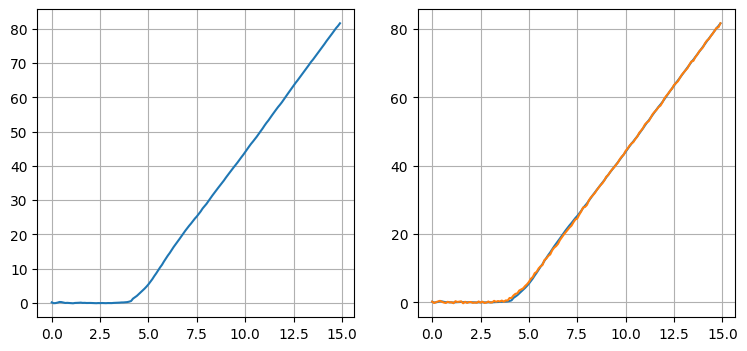

In [25]:
def run_filter_bank():
    dt = 0.1
    cvfilter = make_cv_filter(dt, std=0.2)
    cafilter = make_ca_filter(dt, std=0.2)

    _, zs = generate_data(120, std=0.2)
    z_xs = zs[:, 0]
    xs, probs = [], []

    pv, pa = 0.8, 0.2
    pvsum, pasum = 0., 0.
    
    for z in z_xs:
        cvfilter.predict()
        cafilter.predict()
        cvfilter.update([z])
        cafilter.update([z])
        
        cv_likelihood = cvfilter.likelihood * pv
        ca_likelihood = cafilter.likelihood * pa
        
        pv = (cv_likelihood) / (cv_likelihood + ca_likelihood)
        pa = (ca_likelihood) / (cv_likelihood + ca_likelihood)
        
        x = (pv * cvfilter.x[0]) + (pa*cafilter.x[0])
        xs.append(x)
        probs.append(pv / pa)

    xs = np.asarray(xs)
    t = np.arange(0, len(xs) * dt, dt)
    plt.subplot(121)
    plt.plot(t, xs)
    plt.subplot(122)
    plt.plot(t, xs)
    plt.plot(t, z_xs)
    return xs, probs

xs, probs = run_filter_bank()

Слева я изобразил только оценки фильтра, чтобы вы могли увидеть, насколько гладким получается результат. Справа я построил график как оценок, так и измерений, чтобы доказать, что фильтр отслеживает маневр. 

Еще раз хочу подчеркнуть, что это не что иное, как байесовский алгоритм, который мы использовали на протяжении всей книги. У нас есть два (или более) измерения или оценки, каждая из которых имеет соответствующую вероятность. Мы выбираем оценку как взвешенную комбинацию каждого из этих значений, где веса пропорциональны вероятности правильности. Вычисление вероятности на каждом шаге выглядит следующим образом

$$\frac{\texttt{Prob(meas | state)} \times\texttt{prior}}{\texttt{normalization}}$$

что является теоремой Байеса.

Для решения реальных задач вам, скорее всего, понадобится более двух фильтров в вашем банке. В своей работе я отслеживаю объекты с помощью компьютерного зрения. Я отслеживаю хоккейные шайбы. Шайбы скользят, отскакивают и скользят, катятся, рикошетят, их подбирают и несут, а игроки их быстро "дриблингуют". Я слежу за людьми, которые являются спортсменами, и их способность к нелинейному поведению практически безгранична. Банк из двух фильтров в таких условиях не поможет. Мне нужно смоделировать несколько моделей процессов, различные предположения о шумах, связанных с обнаружением компьютерного зрения, и так далее. Но основную идею вы уловили.

### Ограничения фильтра MMAE

Фильтр MMAE в том виде, в котором я его представил, имеет существенную проблему. Посмотрите на этот график соотношения вероятностей для фильтра постоянной скорости и постоянного ускорения.

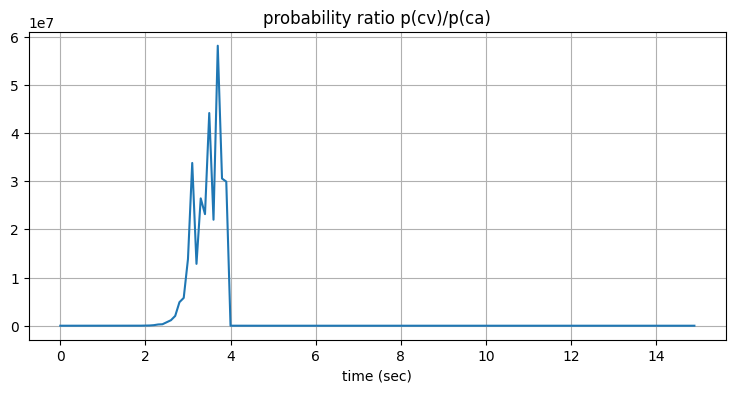

In [26]:
plt.plot(t[0:len(probs)], probs)
plt.title('probability ratio p(cv)/p(ca)')
plt.xlabel('time (sec)');

В течение первых трех секунд, пока отслеживаемый объект движется в прямом направлении, фильтр постоянной скорости становится гораздо более вероятным, чем фильтр постоянного ускорения. Как только начинается маневр, вероятность быстро меняется в пользу модели постоянного ускорения. Однако маневр завершается к шестой секунде. Можно было бы ожидать, что вероятность фильтра постоянной скорости снова станет большой, но вместо этого она остается равной нулю.

Это происходит из-за рекурсивного вычисления вероятности:

$$p_k = \frac{\mathcal{L}p_{k-1}}{\sum \text{probabilities}}$$

Когда вероятность становится очень малой, она уже не может восстановиться. В результате банк фильтров быстро сходится только на наиболее вероятных фильтрах. Надежная схема должна отслеживать вероятность каждого фильтра, отсеивать фильтры с очень низкой вероятностью и заменять их фильтрами с большей вероятностью хорошей работы. Вы можете разделить существующие фильтры на новые фильтры, которые пытаются охватить характеристики, обеспечивающие их хорошую работу. В худшем случае, если фильтр отклонился от нормы, вы можете переинициализировать состояние фильтра, чтобы оно было ближе к текущим измерениям.

## Взаимодействующие множественные модели (IMM)

Давайте подумаем о нескольких моделях с другой стороны. Сценарий остается прежним - мы хотим отслеживать маневрирующую цель. Мы можем разработать набор фильтров Калмана, которые делают различные предположения о моделировании. Они могут отличаться порядком фильтрации или количеством шума в модели процесса. При поступлении каждого нового измерения каждый фильтр имеет вероятность того, что он является правильной моделью.

Этот наивный подход приводит к комбинаторному взрыву. На шаге 1 мы генерируем $N$ гипотез, или 1 на фильтр. На шаге 2 мы генерируем еще $N$ гипотез, которые затем нужно объединить с предыдущими $N$ гипотезами, что дает $N^2$ гипотез. Было опробовано множество различных схем, которые либо отсеивали маловероятные гипотезы, либо объединяли похожие, но эти алгоритмы все равно страдали от вычислительных затрат и/или низкой производительности. Я не буду рассматривать их в этой книге, но в литературе известными примерами являются обобщенные псевдобайесовские алгоритмы (GPB).

Алгоритм *Interacting Multiple Models* (IMM) был изобретен Бломом[5] для решения проблемы комбинаторного взрыва множества моделей. Последующая работа Блома и Бар-Шалома является наиболее цитируемой [6]. Идея состоит в том, чтобы иметь по одному фильтру для каждого возможного режима поведения системы. В каждую эпоху мы позволяем фильтрам *взаимодействовать* друг с другом. Более вероятные фильтры изменяют оценки менее вероятных фильтров таким образом, чтобы они более точно отражали текущее состояние системы. Это смешивание происходит вероятностно, поэтому маловероятные фильтры также изменяют вероятные фильтры, но на гораздо меньшую величину. 

Например, предположим, что у нас есть два режима: движение по прямой или поворот. Каждый режим представлен фильтром Калмана, возможно, фильтром первого и второго порядка. Теперь предположим, что цель поворачивает. Фильтр второго порядка даст хорошую оценку, а фильтр первого порядка будет отставать от сигнала. Функция правдоподобия каждого из них говорит нам, какой из фильтров наиболее вероятен. Вероятность фильтра первого порядка будет низкой, поэтому мы значительно скорректируем его оценку с помощью фильтра второго порядка. Вероятность фильтра второго порядка очень высока, поэтому его оценка будет лишь незначительно изменена фильтром Калмана первого порядка.

Теперь предположим, что цель перестала поворачиваться. Поскольку мы пересматривали оценки фильтра первого порядка вместе с оценками второго порядка, он не будет сильно отставать от сигнала. В течение нескольких эпох он будет давать очень хорошие (высоковероятные) оценки и станет наиболее вероятным фильтром. Затем он начнет вносить значительный вклад в оценку фильтра второго порядка. Напомним, что фильтр второго порядка принимает шум измерений за ускорение. Эта настройка позволяет значительно снизить этот эффект.

### Вероятности режимов

Мы определим набор режимов для нашей системы, $m$, и предположим, что цель всегда находится в одном из этих режимов. В приведенном выше обсуждении мы имеем режимы прямолинейного движения и поворота, поэтому $m=\{\text{straight},\ \text{turn}\}$.


Мы назначаем вероятность того, что цель находится в каком-либо режиме. Это дает нам вектор *вероятностей режимов* с одной вероятностью для каждого возможного режима. У $m$ есть два режима, поэтому у нас будет вектор из двух вероятностей. Если мы считаем, что вероятность того, что цель движется прямо, составляет 70%, мы можем сказать

$$\mu = \begin{bmatrix} 0.7 & 0.3\end{bmatrix}$$

Мы получаем 0,3 для поворота, потому что вероятности должны в сумме равняться единице. $\mu$ обычно, но не повсеместно, используется в качестве символа для вероятности моды, поэтому я буду использовать его. Не путайте его со средним значением.

В Python мы можем реализовать это как

In [27]:
mu = np.array([0.7, 0.3])
mu

array([0.7, 0.3])

Мы можем формализовать это, сказав, что предварительная вероятность того, что $m_i$ верна (маневрирующий объект находится в режиме $i$), учитывая предварительные измерения $Z$, такова

$$\mu_i = P(m_i|Z)$$

### Переходы режимов

Далее мы должны учесть, что это маневрирующая цель. Она будет идти прямо, затем поворачивать, затем снова идти прямо. Мы можем смоделировать переход между этими режимами как [*Марковскую цепь*](https://en.wikipedia.org/wiki/Markov_chain), как показано на этом рисунке:

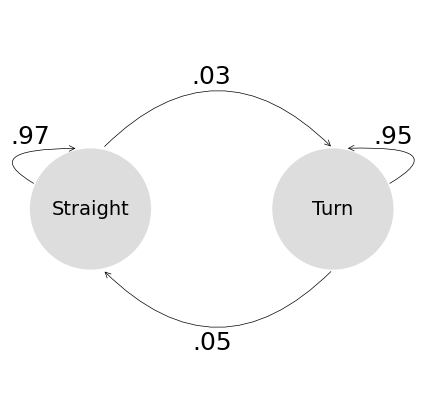

In [28]:
import kf_book.adaptive_internal as adaptive_internal
adaptive_internal.plot_markov_chain()

Здесь показан пример двух режимов для цели: движение по прямой и выполнение поворота. Если текущий режим цели - прямой, то мы предсказываем, что вероятность того, что цель продолжит движение по прямой, составляет 97 %, а вероятность того, что она начнет поворот, - 3 %. Если цель поворачивает, то мы предсказываем, что вероятность того, что она останется в повороте, составляет 95 %, а вероятность возвращения на прямую траекторию - 5 %.

Алгоритм не чувствителен к точным цифрам, и для выбора подходящих значений обычно используется моделирование или испытания. Однако эти значения вполне репрезентативны.

Мы представляем цепи Маркова с помощью [*матрицы вероятностей переходов*](https://en.wikipedia.org/wiki/Stochastic_matrix), которую мы будем называть $\mathbf M$. Для цепи Маркова на рисунке мы напишем

$$\mathbf M = \begin{bmatrix}.97 & .03\\.05 & .95\end{bmatrix}$$

Другими словами, $\mathbf M[i, j]$ - это вероятность того, что режим будет $j$, учитывая, что последний режим был $i$. В данном примере вероятность того, что в данный момент режим является прямым $(j=0)$, учитывая, что последним режимом был поворот $(i=1)$, равна $\mathbf M[1,\ 0] = 0.05$. На языке Python мы бы написали:

In [29]:
M = np.array([[.97, .03], [.05, .95]])
print(M)
print('From turn to straight probablility is', M[1, 0], 'percent')

[[0.97 0.03]
 [0.05 0.95]]
From turn to straight probablility is 0.05 percent


Это позволяет нам вычислять вероятности новых режимов на основе вероятности перехода. Давайте вычислим вероятность того, что после перехода режим будет прямым. Есть два варианта того, как мы можем двигаться прямо. Мы могли двигаться прямо, а затем продолжить движение прямо, или мы могли повернуть, а затем пойти прямо. Первая вероятность вычисляется с помощью $(0,7\times 0,97)$, а вторая - с помощью $(0,3\times 0,05)$. Мы умножаем вероятность режима на соответствующую вероятность из цепи Маркова. Общая вероятность* равна их сумме, или $(0,7)(0,97) + (0,3)(0,05) = 0,694$. 

Вспомните теорему [*общей вероятности*](https://en.wikipedia.org/wiki/Law_of_total_probability) из второй главы. Она гласит, что вероятность нескольких различных событий равна

$$P(A) = \sum P(A\mid B)\, P(B)$$

Здесь $P(A\mid B)$ - матрица перехода $\mathbf M$, а $P(B)$ - $\mu$. Мы используем массивы и матрицы, поэтому воспользуемся тем, что вектор, умноженный на матрицу, вычисляет сумму произведений:

$$\begin{bmatrix}\mu_1 & \mu_2 \end{bmatrix}\begin{bmatrix}m_{11} & m_{12}\\m_{21} & m_{22}\end{bmatrix} = \begin{bmatrix}\mu_1 m_{11} + \mu_2 m_{21} & \mu_1 m_{12} + \mu_2 m_{22}\end{bmatrix}$$

В литературе по IMM это выражается следующим образом

$$\bar c_j = \sum\limits_{i=1}^{N} \mu_i M_{ij}$$

Мы используем функцию NumPy `dot`, чтобы вычислить это для нас. Мы также могли бы использовать оператор умножения matix `@`, но я считаю, что использование точки для символа суммирования, который является точечным произведением, более интуитивно понятно:

In [30]:
cbar = np.dot(mu, M)
cbar

array([0.694, 0.306])

### Вычисление вероятностей режимов


Вычислим новые вероятности режимов, используя теорему Байеса. Напомним, что теорема Байеса гласит

$$\text{posterior} = \frac{\text{prior} \cdot \text{likelihood}}{\text{normalization factor}}$$

Здесь приоритет - это вычисление полной вероятности, которое мы выполнили в предыдущем разделе. Фильтр Калмана вычисляет *вероятность*, которая является вероятностью измерений с учетом текущего состояния фильтра. Для справки уравнение выглядит следующим образом:

$$
\mathcal{L} = \frac{1}{\sqrt{2\pi \mathbf S}}\exp [-\frac{1}{2}\mathbf y^\mathsf T\mathbf S^{-1}\mathbf y]$$

В математических обозначениях вероятность обновленного режима равна:

$$\mu_i = \| \mathcal{L}_i {\bar c}_{i}\|$$

Другими словами, для каждого фильтра Калмана (режима) мы вычисляем вероятность режима как вероятность текущего режима с учетом возможного перехода, умноженную на вероятность того, что это правильный режим. Затем мы нормируем все вероятности, чтобы их сумма равнялась единице.

Это тривиально вычислить в Python. Я введу переменную `L` для хранения вероятностей. Вероятности вычисляются на шаге `KalmanFilter.update()`, и в приведенном ниже фрагменте кода я просто жестко закодировал значения для `L`, поскольку мы еще не создали фильтры Калмана:

In [31]:
# L = [kf0.L, kf1.L]  # get likelihoods from Kalman filters
L = [0.000134, 0.0000748] 
mu = cbar * L
mu /= sum(mu) # normalize
mu

array([0.802, 0.198])

Здесь видно, что относительно высокая вероятность для прямого фильтра увеличила вероятность прямого режима с 70 % до 80,2 %.

## Смешивание вероятностей

На данном этапе мы можем использовать переходы режимов для вычисления вероятностей для всех возможных вариантов. Если $\mu = \begin{bmatrix} 0.63 & 0.27\end{bmatrix}$, то мы можем использовать матрицу вероятностей переходов для вычисления всех возможных исходов. Другими словами, если текущий режим - прямой $(\mu=0,63)$, мы можем вычислить две новые вероятности в зависимости от того, продолжает ли цель двигаться прямо или поворачивает. То же самое мы сделаем для режима поворота $(\mu=0,27)$. От двух вероятностей режима мы перейдем к четырем. На следующем шаге четыре превратятся в восемь, и так далее. Это вычислительно точно, но на практике невыполнимо. После 30 эпох вам потребуется 8 Гб памяти для хранения вероятностей режимов с двойной точностью.

Нам нужен лучший, хотя и приблизительный способ. IMM решают эту проблему, вычисляя *вероятности смешивания*. Идея проста. Допустим, первый режим (прямой) в данный момент очень вероятен, а второй (поворот) - маловероятен. Вместо того чтобы использовать фильтр Калмана для прямого режима, вычислите его состояние как средневзвешенное значение всех фильтров в банке фильтров. Фильтры с высокой вероятностью совпадения с режимом цели взвешиваются больше, чем фильтры с меньшей вероятностью. В результате информация, полученная от вероятных фильтров, повышает точность фильтров, которые являются маловероятными. В этом и заключается суть алгоритма.

Все, что нам нужно сделать, очень просто. Каждый фильтр Калмана выполняет шаг обновления, вычисляя новое среднее и ковариацию. Но затем мы вычисляем новое среднее и ковариацию для каждого фильтра как взвешенную сумму этих средних и ковариаций в соответствии с *вероятностями смешивания*, которые мы называем $\omega$. Вероятные фильтры будут слегка скорректированы маловероятными фильтрами, а маловероятные фильтры будут сильно скорректированы вероятными фильтрами. В литературе эти скорректированные средние и ковариации называют *смешанными условиями* или *смешанными начальными условиями*. Я использую обозначение $\mathbf x^m_j$ для смешанного состояния и $\mathbf P^m_j$ для смешанной ковариации. Уравнения таковы:

$$\begin{aligned}
\mathbf x^m_j &= \sum_{i=1}^N \omega_{ij} \mathbf x_i \\
\mathbf P^m_j &= \sum_{i=1}^N \omega_{ij}\left[(\mathbf x^i - \mathbf  x^m_i) (\mathbf x^i - \mathbf  x^m_i)^\mathsf T + \mathbf P_i\right]
\end{aligned}$$

Считайте, что подскрипты - это индексы в массивах. Выражаясь на псевдо-Python, мы можем записать это так:

```python
for j in N:
    x0[j] = sum_over_i(w[i,j] * x[i])
    P0[j] = sum_over_i(w[i, j] * (P[i] + np.outer(x[i] - x0[j]))) 
```

Не позволяйте обозначениям запутать простую идею: включите оценки вероятных фильтров в оценки невероятных фильтров, чтобы все они имели хорошую оценку.

Как вычислить вероятности смешивания? Подумайте об этом и постарайтесь дать разумный ответ, прежде чем читать дальше. У нас есть вероятности режимов, которые описывают текущую вероятность каждого режима, а затем вероятности перехода, описывающие, насколько вероятно, что мы изменим режим. Как вычислить новую вероятность?

Конечно же, с помощью теоремы Байеса! Приор умножается на вероятность, нормированную на вероятность. Приор - это вероятность режима, а вероятность определяется цепью Маркова, которую мы храним в матрице $\mathbf M$.

$$\boldsymbol\omega_{ij} = \| \mu_i \cdot \mathbf M_{ij}\|$$

Мы можем вычислить это следующим образом. Выше я вычислил обновление $\mu$ и $\bar c$ не по порядку (вы должны вычислить $\bar c$, включив матрицу вероятностей перехода в $\mu$), поэтому здесь мне нужно это исправить:

In [32]:
cbar = np.dot(mu, M) #compute total probability that target is in mode j

omega = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        omega[i, j] = (M[i, j] * mu[i]) / cbar[j]
omega

array([[0.987, 0.114],
       [0.013, 0.886]])

Фильтры Калмана должны выполнить шаг предсказания, чтобы вычислить новое предшествующее значение. Они используют смешанные оценки:

$$
\begin{aligned}
\bar{\mathbf x}_j &= \mathbf F_j\mathbf x^m_j\\
\bar{\mathbf P}_j &= \mathbf F_j\mathbf P^m_j\mathbf F_j^\mathsf T + \mathbf Q_j
\end{aligned}$$

### Оценка IMM

Теперь нам нужна окончательная оценка состояния банка фильтров. Как это сделать? Просто взвесьте смешанную оценку от каждого фильтра Калмана:

$$\begin{aligned}
\mathbf x &= \sum_{j=1}^N \mu_j{\bar{\mathbf x}}_j\\
\mathbf P &= \sum_{j=1}^N \mu_j\left[(\bar{{\mathbf x}}_j - \bar{\mathbf x})({\bar{\mathbf x}}_j - \bar{\mathbf x})^\mathsf T + \bar{\mathbf P_j}\right]
\end{aligned}$$

### Отслеживание маневрирующей цели с помощью IMM

Давайте разберем пример. Крассидис[4] - один из немногих текстов с отработанным примером, поэтому я выбрал его пример. Он отслеживает движущуюся цель в течение 600 секунд. Вначале цель движется прямо, а затем, начиная с 400 секунды, подается управляющий сигнал, заставляющий цель повернуть на 90 градусов. Он использует два фильтра Калмана с постоянным ускорением. Один фильтр предполагает отсутствие шума процесса, а другой - шум процесса со спектральной плотностью $10^{-3}\mathbf I$. Он предполагает очень хорошую инициализацию фильтров, устанавливая $\mathbf P =10^{-12}$ для обоих фильтров. Моя реализация выглядит следующим образом:

/var/folders/9r/x5ypg1z565b7mkpx1jq005980000gn/T/ipykernel_55506/2496033518.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zs[i, 0] = imm_track[i, 0] + randn()*r
/var/folders/9r/x5ypg1z565b7mkpx1jq005980000gn/T/ipykernel_55506/2496033518.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zs[i, 1] = imm_track[i, 2] + randn()*r


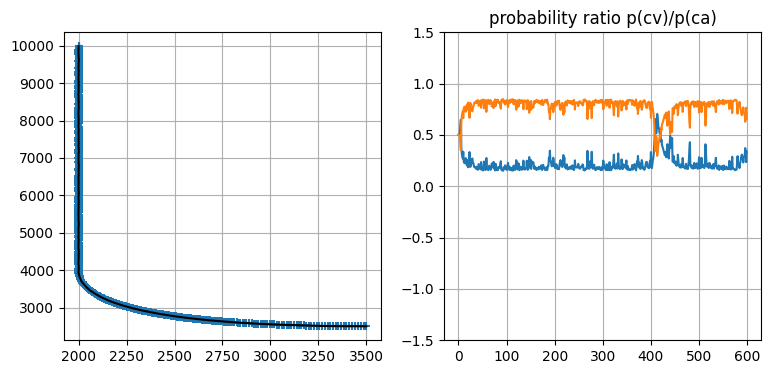

In [33]:
import copy
from scipy.linalg import block_diag
from filterpy.kalman import IMMEstimator
from filterpy.common import Saver

N = 600
dt = 1.
imm_track = adaptive_internal.turning_target(N)

# create noisy measurements
zs = np.zeros((N, 2))
r = 1
for i in range(N):
    zs[i, 0] = imm_track[i, 0] + randn()*r
    zs[i, 1] = imm_track[i, 2] + randn()*r

ca = KalmanFilter(6, 2)
dt2 = (dt**2)/2
F = np.array([[1, dt, dt2],
              [0,  1,  dt],
              [0,  0,   1]])
            
ca.F = block_diag(F, F)
ca.x = np.array([[2000., 0, 0, 10000, -15, 0]]).T
ca.P *= 1.e-12
ca.R *= r**2
q = np.array([[.05, .125, 1/6],
              [.125, 1/3, .5],
              [1/6, .5, 1]])*1.e-3
ca.Q = block_diag(q, q)
ca.H = np.array([[1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0]])

# create identical filter, but with no process error
cano = copy.deepcopy(ca)
cano.Q *= 0

filters = [ca, cano]

M = np.array([[0.97, 0.03],
              [0.03, 0.97]])
mu = np.array([0.5, 0.5])
bank = IMMEstimator(filters, mu, M)

xs, probs = [], []
for i, z in enumerate(zs):
    z = np.array([z]).T
    bank.predict()
    bank.update(z)

    xs.append(bank.x.copy())
    probs.append(bank.mu.copy())

xs = np.array(xs)
probs = np.array(probs)
plt.subplot(121)
plt.plot(xs[:, 0], xs[:, 3], 'k')
plt.scatter(zs[:, 0], zs[:, 1], marker='+')

plt.subplot(122)
plt.plot(probs[:, 0])
plt.plot(probs[:, 1])
plt.ylim(-1.5, 1.5)
plt.title('probability ratio p(cv)/p(ca)');

Наглядно увидеть работу фильтра довольно сложно, поэтому давайте посмотрим на его работу в момент начала поворота. Я поменял местами оси $x$ и $y$, чтобы мы могли приблизить изображение. На графике ниже поворот начинается в точке $Y=4000$. Если вы посмотрите очень внимательно, то увидите, что оценка немного колеблется после начала поворота, но фильтр отслеживает измерение без запаздывания, и вскоре оно становится плавным.

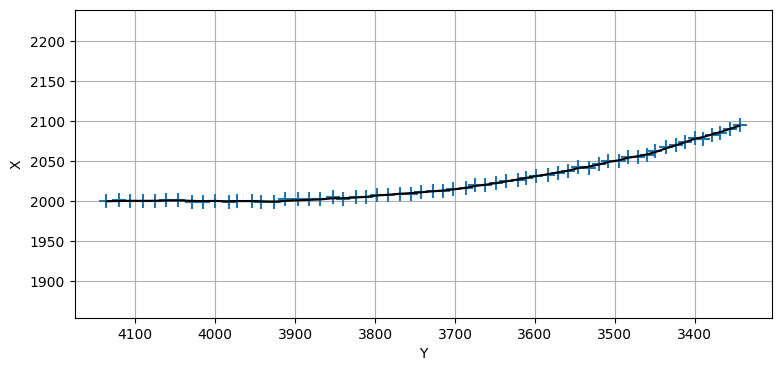

In [34]:
plt.plot(xs[390:450, 3], xs[390:450, 0], 'k')
plt.scatter(zs[390:450, 1], zs[390:450, 0], marker='+', s=100);
plt.xlabel('Y'); plt.ylabel('X')
plt.gca().invert_xaxis()
plt.axis('equal');

### Ограничения IMM

Я не работал с IMM, поэтому не могу ответить на этот вопрос так хорошо, как хотелось бы. Однако IMM был изобретен для отслеживания маневрирующих самолетов для управления воздушным движением, и, по всем отзывам, он прекрасно справляется с этой ролью. 

Этот вариант использования предполагает несколько вещей. Прежде всего, это требование, чтобы все фильтры в банке имели одинаковую размерность. Обзор математики должен показать, почему. Для создания смешанной оценки IMM выполняет следующее вычисление:

$$\mathbf x = \sum_{j=1}^N \mu_j{\bar{\mathbf x}}_j$$

Это вычислимо тогда и только тогда, когда состояние $x$ в каждом фильтре имеет одинаковую размерность. Более того, интерпретация $x[i]$ должна быть одинаковой для каждого фильтра. 

Например, предположим, что мы попытались создать фильтр, использующий модель постоянной скорости, а другой - модель постоянного ускорения. Это не сработает, потому что размерность $x$ разная. `FilterPy` выдаст ошибку `ValueError`, если вы попытаетесь использовать фильтры с разными размерностями.

In [35]:
ca = KalmanFilter(3, 1)
cv = KalmanFilter(2, 1)

trans = np.array([[0.97, 0.03],
                  [0.03, 0.97]])

imm = IMMEstimator([ca, cv], (0.5, 0.5), trans)

ValueError: All filters must have the same state dimension

Время от времени я получаю письма или сообщения об ошибках по этому поводу. В прошлом я рекомендовал спроектировать фильтр с постоянной скоростью в размерности 3, а затем реализовать `F` для игнорирования ускорения.

```python
F = np.array([[1, dt, 0],
              [0, 1,  0],
              [0, 0,  0]])
```

Оглядываясь назад, я не уверен, что это разумная рекомендация. Это позволяет IMM работать, но очевидно, что оценка ускорения будет неверной, поскольку один фильтр будет иметь точную оценку ускорения, а другой - 0. Это неточное ускорение будет использоваться для выполнения следующего цикла предсказания. 

Рассмотрим более экстремальный случай. Предположим, один из ваших фильтров интерпретирует `x[2]` как ускорение, а другой - как угловую скорость вращения. Очевидно, что `x[2]` смешанной оценки будет бессмысленным, поскольку вы не можете суммировать (линейное) ускорение со скоростью вращения.

Как я уже сказал, я не особенно хорошо разбираюсь в IMM. Возможно, в литературе объясняется, как поступать в таких ситуациях. Все, что я могу сказать, это то, что IMM, реализованный в FilterPy, не будет работать для этих случаев использования.

IMM, разработанный для управления воздушным движением, использует фильтры с различными предположениями о процессе. Самолет может лететь ровно, может снижаться/подниматься, может выполнять скоординированный или нескоординированный поворот. Вы можете разработать фильтр для каждого случая с различными матрицами `F` и `Q`, но оценка состояния `x` будет одинаковой для всех.

## Резюме

Эта глава содержит некоторые из наиболее сложных материалов в этой книге. Однако она открывает путь к реализации реалистичных фильтров Калмана. Если мы управляем роботом, мы знаем его модель процесса, и для нее легко построить фильтр Калмана. Гораздо чаще нам дают набор данных временного ряда и просят разобраться в них. Модель процесса нам в основном неизвестна. Мы используем методы, описанные в этой главе, чтобы *научиться* (в смысле машинного обучения), как параметризовать наши модели. Модели меняются с течением времени по мере маневрирования цели, поэтому наши фильтры должны быть адаптивными. 

Поиск оптимального ответа влечет за собой комбинаторный взрыв, и на практике это непрактично. Алгоритм IMM стал стандартным алгоритмом благодаря своей хорошей производительности и вычислительной простоте.

Настоящий банк фильтров обычно включает в себя более двух фильтров. Обычно фильтров бывает много. По мере изменения режима цели некоторые фильтры становятся бесконечно маловероятными. Большинство адаптивных фильтров реализуют алгоритм, который уничтожает крайне маловероятные фильтры и заменяет их фильтрами, более соответствующими текущему режиму. Это очень специфично для вашего проблемного пространства и, как правило, очень нестандартно. Вам нужно будет разработать схемы уничтожения и создания фильтров и протестировать их на симулированных или реальных данных. 

Несмотря на сложность алгоритмов, я надеюсь, вы понимаете, что идеи, лежащие в их основе, очень просты. Мы используем те же два инструмента, которые изучали во второй главе: теорему Байеса и теорему о полной вероятности. Мы включаем новую информацию, используя теорему Байеса, и вычисляем эффект от моделей процессов, используя теорему о суммарной вероятности.

Для меня эта глава подчеркивает красоту байесовской формулировки фильтров Калмана. Меня не очень волнует, узнаете ли вы подробности алгоритма IMM. Я надеюсь, что вы увидите, что очень простые вероятностные рассуждения привели к таким результатам. Уравнения линейной алгебры фильтра Калмана, которые вывел доктор Калман, были получены в результате другой формы рассуждений, называемой *ортогональной проекцией*. Это по-своему прекрасно, и я настоятельно рекомендую вам прочитать его статью. Но я не уверен, что нахожу их интуитивно понятными в использовании, и совершенно не ясно, как с помощью этих методов разработать новые, неоптимальные фильтры, такие как IMM. В отличие от них, теорема Байеса позволяет нам с легкостью решать эти проблемы.

## Ссылки

 * [1] Bar-Shalom, Y., Xiao-Rong L., and Thiagalingam Kirubarajan. *Estimation with Applications to Tracking and Navigation*. New York: Wiley, p. 424, 2001. 


* [2] Zarchan, P., and Musoff, H., *Fundamentals of Kalman Filtering: A Practical Approach* Fourth Edition. Reston, VA: American Institute of Aeronautics and Astronautics, p.584-595, 2015. 


* [3] Simon, D., *Optimal State Estimation: Kalman, H and Nonlinear Approaches*. Hoboken, NJ: Wiley-Interscience, p. 208-212, 2006


* [4] Crassidis, John L., and John L. Junkins. *Optimal estimation of dynamic systems*. CRC press, 2011.


* [5] Blom, H.A.P., "An Efficient Filter for Abruptly Changing Systems", *Proceedings of 23rd Conference on Decision and Control*, Las Vegas, NV, Dec 1984.


* [6] Blom, H.A.P and Bar-Shalom, Y., "The Interacting Multiple Model Algorithm for Systems with Markovian Switching Coefficients", *IEEE Transactions on Automatic Control*, Vol. AC-8, No. 8, Aug. 1998, pp. 780-783.